# SEIRS Adaptive Sampling - Iterative Breakdown

## SEIRS Model

**Problem description**:

The SEIRS model describes the spread of a disease in a population fixed to $N$ individuals over time $t$. Furthermore, the model divides the population into four categories, called "S", "E", "I", and "R". The extra "S" at the end usually means we include the loss of immunity.
- "S" consists of individuals who are susceptible to the disease being modeled.
- "E" consists of individuals who are exposed to the disease. Diseases (like COVID-19) often have an incubation period or a latency period and this category accommodates it. (The SIR model does not have this category.)
- "I" consists of individuals infected with the disease and are capable of infecting others.
- "R" consists of individuals who can be removed from the system, e.g., because they have gained immunity to the disease, or because they have succumbed to the disease.

The SEIR model, like many other epidemiological models depends on particular parameters, which are the following :
 - $\beta>0$ The rate of contraction of the disease (transmission parameter)
 - $ \sigma >0$ The incubation rate i.e. the rate at which exposed hosts become infected
 - $\gamma>0$ : The mean recovery rate
 - $\xi>0$ : The loss of immunity rate. 
 
Individual $S$ becomes infected after positive contact with an $I$ individual. However, he develops immunity to the disease : he leaves $I$ category at a $\gamma$ cure rate. However with a rate $\xi$, they may lose immunity to the disease and rejoin the susceptible population $S$.

**Model Assumptions**

- Model is deterministic
- On average, an individual $S$ in the population encounters $\beta$ individuals per unit time.
- The rate of infected individuals leaving category $I$ is $\gamma I$ per unit time (once an individual has been infected, he develops immunity to the disease).
- The population size $N=S+E+I+R$ is constant.
- Note constant average number of contacts $\beta$ is a strong and constraining assumption : it cannot be applied to all diseases.

This is the system of equations of the model :

The total population $N$ in the system (the sum of individuals in all categories) is likely to be quite large. Instead of working with such large numbers, let us divide each side of each equation by $\mathbf{N}$ and work instead with the proportions
$$
s=\frac{S}{N}, \quad e=\frac{E}{N}, \quad i=\frac{I}{N}, \quad r=\frac{R}{N} .
$$
The equivalent ODE system to be solved for the unknown functions $s(t), e(t), i(t)$, and $r(t)$, has now become
$$
\begin{aligned}
& \frac{d s}{d t}=-\beta i s  + \xi r\\
& \frac{d e}{d t}=\beta i s-\sigma e \\
& \frac{d i}{d t}=\sigma e-\gamma i \\
& \frac{d r}{d t}=\gamma i - \xi r
\end{aligned}
$$
When supplemented with some initial conditions, say
$$
s(0)=0.99, \quad e(0)=0.01, \quad i(0)=0, \quad r(0)=0
$$
This is the formulation of the Initial Value Probelm we wish to solve. Note that the above initial conditions correspond to a starting scenario where just $1 \%$ of the population is exposed.


In [67]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import importlib
from pydci.examples import seirs
import pydci.consistent_bayes.OfflineSequential as os
import pydci.consistent_bayes.OfflineSequentialSearch as oss
from pydci.log import enable_log, disable_log, logger
from pydci.utils import get_l2_errs, set_seed

importlib.reload(seirs)

SEIRS_PARAM_MINS = 4 * [0]
SEIRS_STATE_MINS = 1e-10
SEIRS_STATE_MAXS = 1

# For periodic behavior
R_0 = 3

# Sample every week
SEIRS_SAMPLE_TS = 1

# Populations are all from 0-1 -> Fraction of population
SEIRS_NOISE = 0.001

# Parameters from bjornstad2020seirs paper
SEIRS_P1 = [
    R_0 / 14.0,  # beta transmission rate - R_0 / gamma -> R_0 > 0 for periodic behavior
    1.0
    / 7.0,  # sigma incubation rate i.e. rate at which exposed hosts become infected - 1 week
    1.0 / 14.0,  # gamma  mean recovery rate - 2 weeks
    1.0 / 365.0,  # xi - loss off imunity rate - 1 year
]

# (1) Policy Lockdown 1 month in: => Slower Transmission Rate(beta) - Time 75
SEIRS_P2 = [
    0.5 * R_0 / 14.0,  # transmission rate halved
    1.0 / 7.0,  # sigm
    1.0 / 14.0,
    1.0 / 365.0,
]
# (2) Virus Mutation 1 year in: => Faster Incubation Rate (sigma) - Time 150
SEIRS_P3 = [
    1.2 * R_0 / 14.0,  # transmission rate increased -> Faster transmitting virus
    1.0 / 3.5,  # Incubation rate halved -> Exposed hosts become infected quicker
    1.0 / 14.0,
    1.0 / 365.0,
]

SEIRS_X0 = [
    0.98,  # susceptible
    0.010,  # exposed
    0.010,  # infected
    0,  # recovered
]

# Uniform over range +- 1* true values
SEIRS_DEF_INIT = [
    "uniform",
    {"scale": 1.0},
]

# enable_log(level='DEBUG')
n_samples = 1000
total_time = 1 * 365.25
param_shifts = {0: SEIRS_P1, 25: SEIRS_P2, 150: SEIRS_P3}

In [3]:
from scipy.stats import gautssian_kde

def solve_till_thresh(
    model,
    data_idx,
    exp_thresh=0.1,
    start_sample_size=100,
    max_sample_size=200,
    samples_inc=10,
    pi_in=None,
    sampling_args={},
    clear=False,
    **solve_args,
):
    """
    """
    data_idx = data_idx if data_idx != -1 else len(model.data) - 1

    def _get_samples(init, ss):
        if init is None:
            init, samples = model.get_initial_samples(
                num_samples=ss, **sampling_args
            )
        else:
            if not isinstance(init, gaussian_kde):
               samples = init.rvs((ss, model.n_params)).T
            else:
                samples = init.resample(ss).T

        return init, samples

    if len(model.samples) <= data_idx or clear:
        # * First batch if not continuing from previous solve
        # * Or if clearing previous solve when clear = True
        pi_in, samples = _get_samples(pi_in, start_sample_size)
        model.forward_solve(samples, append=False)

    sample_size = len(model.samples[data_idx])
    solved = False
    while not solved:
        logger.debug(f"Solving using {sample_size} samples")
        prob = oss.OfflineSequentialSearch(
            model.samples[data_idx],
            model.data[data_idx],
            model.measurement_noise,
            pi_in=pi_in,
        )
        solve_args['exp_thresh'] = exp_thresh
        try:
            prob.solve(**solve_args)
        except RuntimeError as r:
            logger.debug(f"Failed: {r}")
        else:
            solved = True
        
        if sample_size >= max_sample_size:
            logger.debug(f"Reached max sample size of {max_sample_size}")
            break
        elif not solved:
            logger.debug(f"Drawing {samples_inc} more samples.")
            samples = _get_samples(pi_in, samples_inc)
            sample_size += samples_ic
            logger.debug(f"Solving forward model for {samples_inc} more samples")
            model.forward_solve(samples, append=True)
        
    return prob

## Problem Set-Up

[08/08/23 21:33:01] INFO     Logger initialized                                                           ]8;id=792290;file:///Users/carlos/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=383955;file:///Users/carlos/repos/pyDCI/src/pydci/log.py#80\80]8;;\

                    DEBUG    State idxs set at 1 of 4 total indices                                     ]8;id=960218;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=323534;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#99\99]8;;\

                    INFO     Getting data for model from 0 to 365.25                                   ]8;id=757068;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=913086;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#354\354]8;;\

                    DEBUG    Shapes: (3652, 1), (3652, 4), (3652,)                                     ]8;id=305265;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=850537;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#369\369]8;;\

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

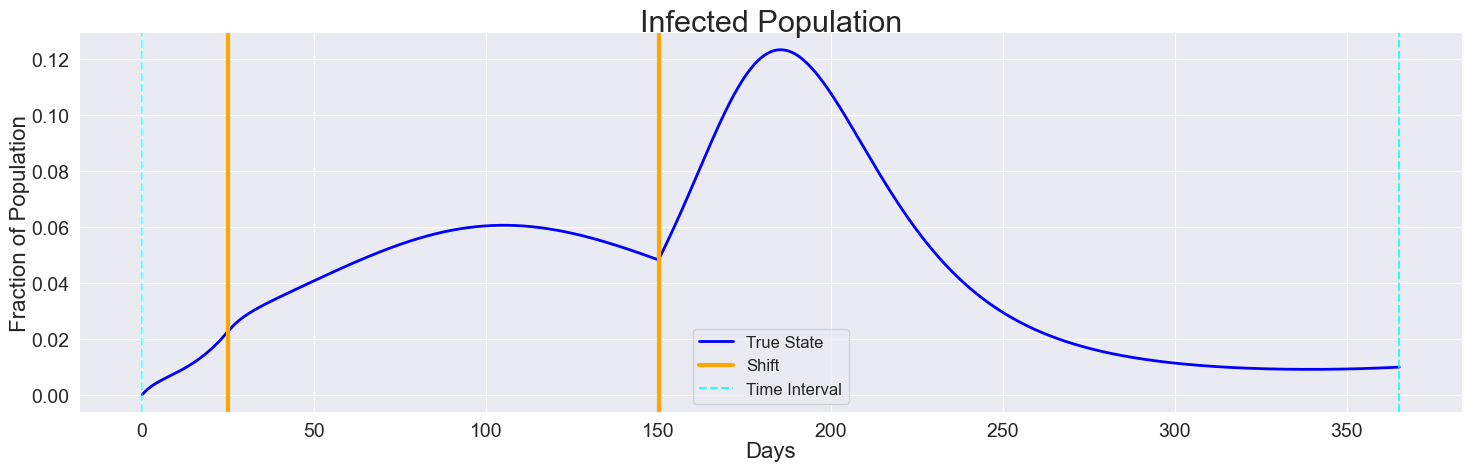

In [4]:
enable_log(level="DEBUG")
full_sr = seirs.SEIRSModel(
    lam_true=SEIRS_P1,
    param_shifts=param_shifts,
    measurement_noise=SEIRS_NOISE,
    sample_ts=SEIRS_SAMPLE_TS,
    state_mins=SEIRS_STATE_MINS,
    state_maxs=SEIRS_STATE_MAXS,
    def_init=SEIRS_DEF_INIT,
)

# pi_in, samples = full_sr.get_uniform_initial_samples(num_samples=1, scale=0.1)
res = full_sr.get_data(t0=0, tf=total_time)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
full_sr.plot_infected(plot_samples=False, plot_measurements=False, ax=ax)

# Online Iteartive - Algorithm Breakdowns

- Use fixed chunks of data, and a fixed set of "search" parameters per chunk of data
- Always re-sample between chunks of data.
- "Search" parameter determine the sets of solution parameters to use for each chunk when trying to solve the problem.
- Search params can vary the:

    1. \# of principal components
    2. \# of splits to use on the chunk of data, for doing offline iterative estimation.
    3. \# of total data points to use, i.e. whether to only use a fraction of the data chunk.


In [5]:
total_time = 1 * 365.25
max_nc = 1
data_chunk_size = 7
n_chunks = int(total_time / data_chunk_size)

sr = seirs.SEIRSModel(
    lam_true=SEIRS_P1,
    param_shifts=param_shifts,
    measurement_noise=SEIRS_NOISE,
    sample_ts=SEIRS_SAMPLE_TS,
    state_mins=SEIRS_STATE_MINS,
    state_maxs=SEIRS_STATE_MAXS,
    def_init=SEIRS_DEF_INIT,
)

[08/08/23 21:33:03] DEBUG    State idxs set at 1 of 4 total indices                                     ]8;id=583334;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=915959;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#99\99]8;;\

## Step by step - Frist 5 Iterations Breakdown

In [6]:
probs = []
n_samples = 100
e_r_thresh = 0.1

### Frist Iteration

Note we can retry the block below if the next solve fails, adding more samples to the problem.

In [7]:
# enable_log(level='DEBUG')
disable_log()

try:
    sr.get_data(tf=7)
except ValueError as v:
    print(v)

In [8]:
prob_1 = solve_till_thresh(
    sr,
    0,
    exp_thresh=0.1,
    start_sample_size=1000,
    max_sample_size=2000,
    samples_inc=100,
    pi_in=None,
    clear=True,
    sampling_args={'scale': 1.0},
    search_exp_thresh=1e10,
    best_method='max_kl',
)

[08/08/23 21:33:08] DEBUG    Solving using 1000 samples                                            ]8;id=376145;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_5560/3227771293.py\3227771293.py]8;;\:]8;id=802545;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_5560/3227771293.py#41\41]8;;\

Solving for different combinations |████████████████████████████████████████| 8/


In [9]:
prob_1.result

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,num_splits,search_index,predict_delta,within_thresh,closest,max_kl,min_kl
0,0.978428,1.142926,0.332434,0.113806,0.120937,0.000982,674,[0],"range(0, 8)",1,0,0.021572,True,True,True,False


In [10]:
prob_1.search_results

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,num_splits,search_index,predict_delta,within_thresh,closest,max_kl,min_kl
0,0.978428,1.142926,0.332434,0.113806,0.120937,0.000982,674,[0],"range(0, 8)",1,0,0.021572,True,True,True,False
0,1.030085,0.611233,0.312847,0.121448,0.109861,0.004861,763,[0],"range(4, 8)",2,1,0.030085,True,False,False,True
0,0.553834,1.175996,0.423932,0.110957,0.022748,0.005479,180,"[0, 1]","range(0, 8)",1,2,0.446166,False,False,False,False
0,0.501790,1.169283,0.042524,0.147318,0.108577,0.001191,612,"[0, 1]","range(4, 8)",2,3,0.498210,False,False,False,False
0,0.329627,1.484148,0.042524,0.147318,0.108577,0.001191,612,"[0, 1, 2]","range(0, 8)",1,4,0.670373,False,False,False,False
0,0.010447,0.900078,0.001198,0.222201,0.142143,0.002770,386,"[0, 1, 2]","range(4, 8)",2,5,0.989553,False,False,False,False
0,0.013475,1.739197,0.169698,0.283468,0.129934,0.001700,213,"[0, 1, 2, 3]","range(0, 8)",1,6,0.986525,False,False,False,False
0,0.000019,1.036348,0.005543,0.234321,0.128510,0.004115,833,"[0, 1, 2, 3]","range(4, 8)",2,7,0.999981,False,False,False,False


In [11]:
# TODO: No exp threshold on 
pd.concat([prob_1.result for prob_1 in prob_1.probs] )

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,num_splits
0,0.978428,1.142926,0.332434,0.113806,0.120937,0.000982,674,[0],"range(0, 8)",1
0,1.030085,0.611233,0.312847,0.121448,0.109861,0.004861,763,[0],"range(4, 8)",2
0,0.553834,1.175996,0.423932,0.110957,0.022748,0.005479,180,"[0, 1]","range(0, 8)",1
0,0.501790,1.169283,0.042524,0.147318,0.108577,0.001191,612,"[0, 1]","range(4, 8)",2
0,0.329627,1.484148,0.042524,0.147318,0.108577,0.001191,612,"[0, 1, 2]","range(0, 8)",1
0,0.010447,0.900078,0.001198,0.222201,0.142143,0.002770,386,"[0, 1, 2]","range(4, 8)",2
0,0.013475,1.739197,0.169698,0.283468,0.129934,0.001700,213,"[0, 1, 2, 3]","range(0, 8)",1
0,0.000019,1.036348,0.005543,0.234321,0.128510,0.004115,833,"[0, 1, 2, 3]","range(4, 8)",2


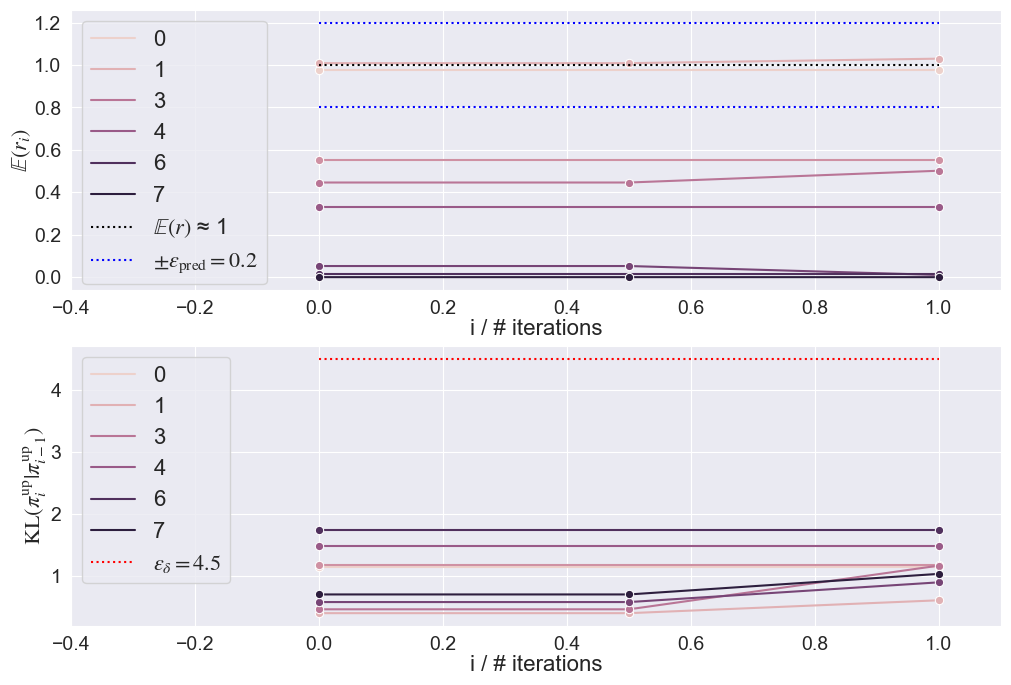

In [12]:
# TODO: Fade-out those that violate criteria?
prob_1.joint_metric_plot()

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

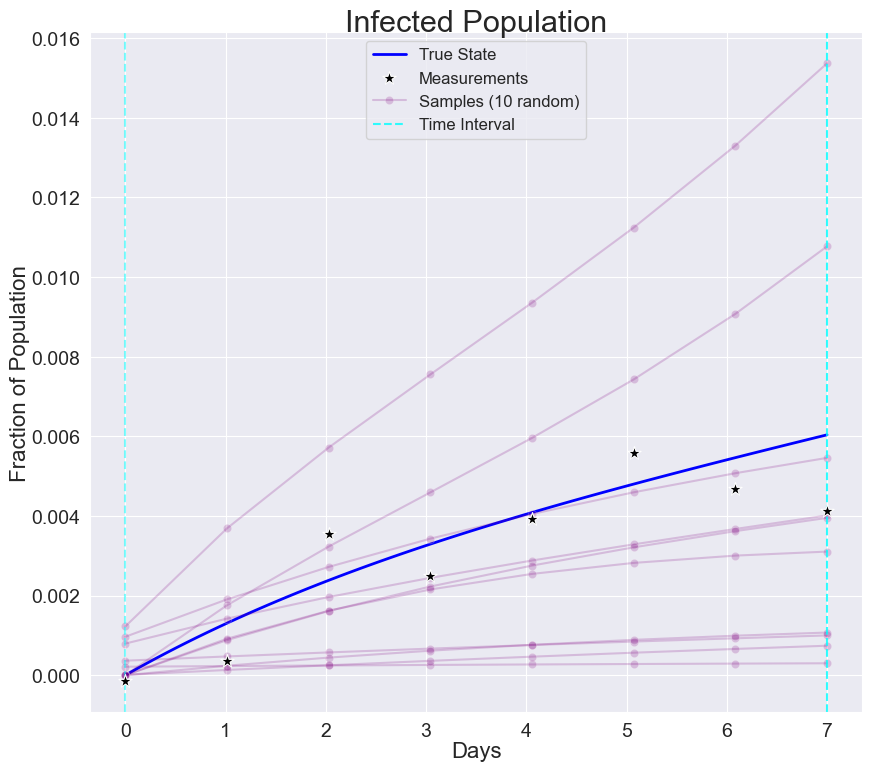

In [13]:
sr.plot_infected()

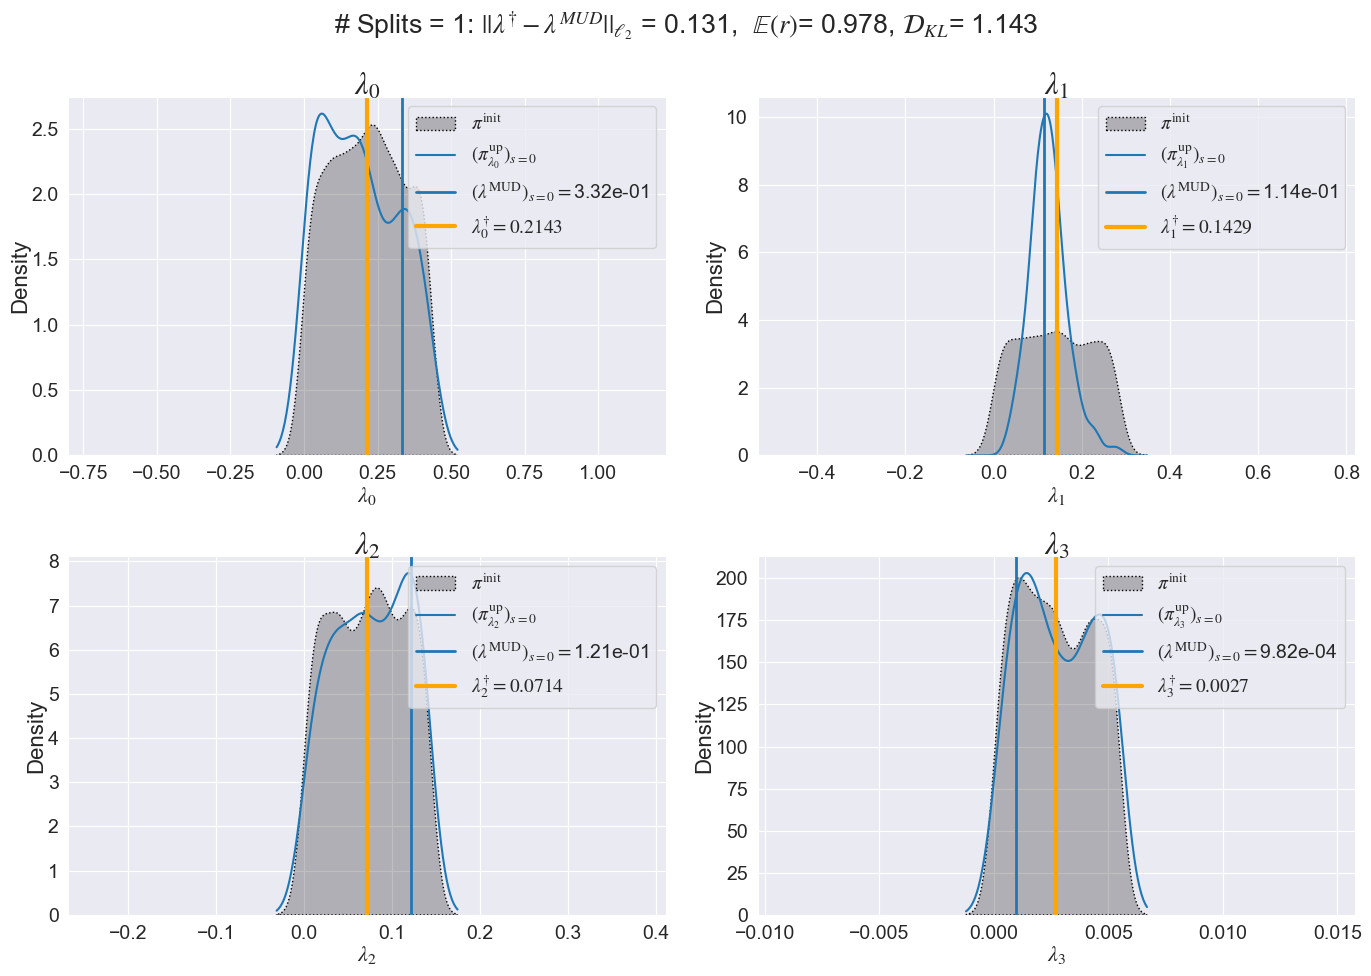

In [14]:
prob_1.param_density_plots(search_idxs=[0], lam_true=sr.lam_true)

### Second Iteration

In [15]:
_ = prob_1.best.sample_dist(1, dist='pi_up')
pi_up_1 = prob_1.best.dists["pi_up"]
pi_up_1

In [16]:
disable_log()

try:
    sr.get_data(tf=14)
except ValueError as v:
    print(v)

In [17]:
enable_log(level='DEBUG', file='test.log')
prob_2 = solve_till_thresh(
    sr,
    1,
    clear=True,
    start_sample_size=1000,
    max_sample_size=2000,
    samples_inc=100,
    pi_in=pi_up_1,
    sampling_args={'scale': 1.0},
    search_exp_thresh=1e10,
    best_method='closest',
)
prob_2.n_samples

Solving for different combinations |████████████████████████████████████████| 8/


1000

In [18]:
prob_2.result

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,num_splits,search_index,predict_delta,within_thresh,closest,max_kl,min_kl
0,1.020149,1.026909,0.10911,0.123849,0.048563,0.002231,763,[0],"range(0, 8)",1,0,0.020149,True,True,False,False


In [19]:
prob_2.full_search_results

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,i,num_splits,search_index,predict_delta,within_thresh,closest,max_kl,min_kl
0,1.020149,1.026909,0.109110,0.123849,0.048563,0.002231,763,[0],"range(0, 8)",0,1,0,0.020149,True,False,False,False
0,1.018016,0.236571,0.046741,0.136448,0.045402,0.001706,611,[0],"range(0, 4)",0,2,1,0.018016,True,True,False,True
0,1.031461,0.870482,0.138510,0.125668,0.048874,0.001983,828,[0],"range(4, 8)",1,2,1,0.031461,True,False,False,False
0,1.055756,1.183318,0.213296,0.118180,0.077286,0.000717,820,"[0, 1]","range(0, 8)",0,1,2,0.055756,True,False,True,False
0,0.913096,0.294802,0.162142,0.117585,0.091542,0.002004,620,"[0, 1]","range(0, 4)",0,2,3,0.086904,True,False,False,False
0,0.411162,1.932618,0.108294,0.287620,0.107551,0.002478,976,"[0, 1]","range(4, 8)",1,2,3,0.588838,False,False,False,False
0,0.767940,1.382404,0.010758,0.178867,0.068549,0.002042,466,"[0, 1, 2]","range(0, 8)",0,1,4,0.232060,False,False,False,False
0,0.204278,0.417906,-0.037960,0.207457,0.152819,0.001934,772,"[0, 1, 2]","range(0, 4)",0,2,5,0.795722,False,False,False,False
0,0.004090,2.017144,0.066323,0.252288,0.094997,0.003648,822,"[0, 1, 2]","range(4, 8)",1,2,5,0.995910,False,False,False,False
0,0.012605,1.687283,0.010758,0.178867,0.068549,0.002042,466,"[0, 1, 2, 3]","range(0, 8)",0,1,6,0.987395,False,False,False,False


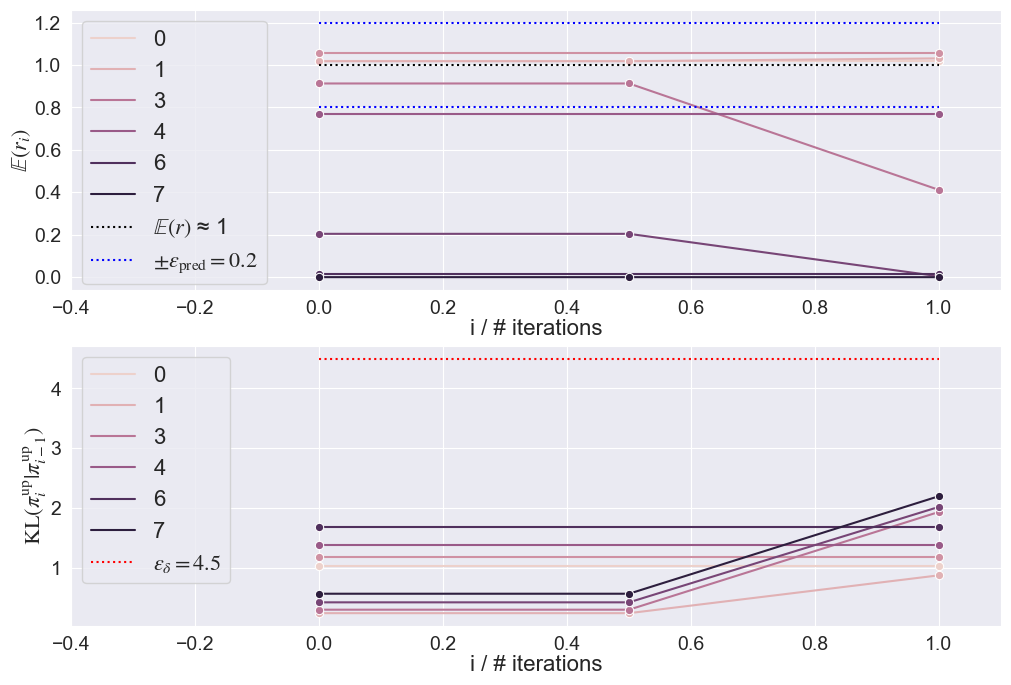

In [20]:
# TODO: Fade-out those that violate criteria?
prob_2.joint_metric_plot()

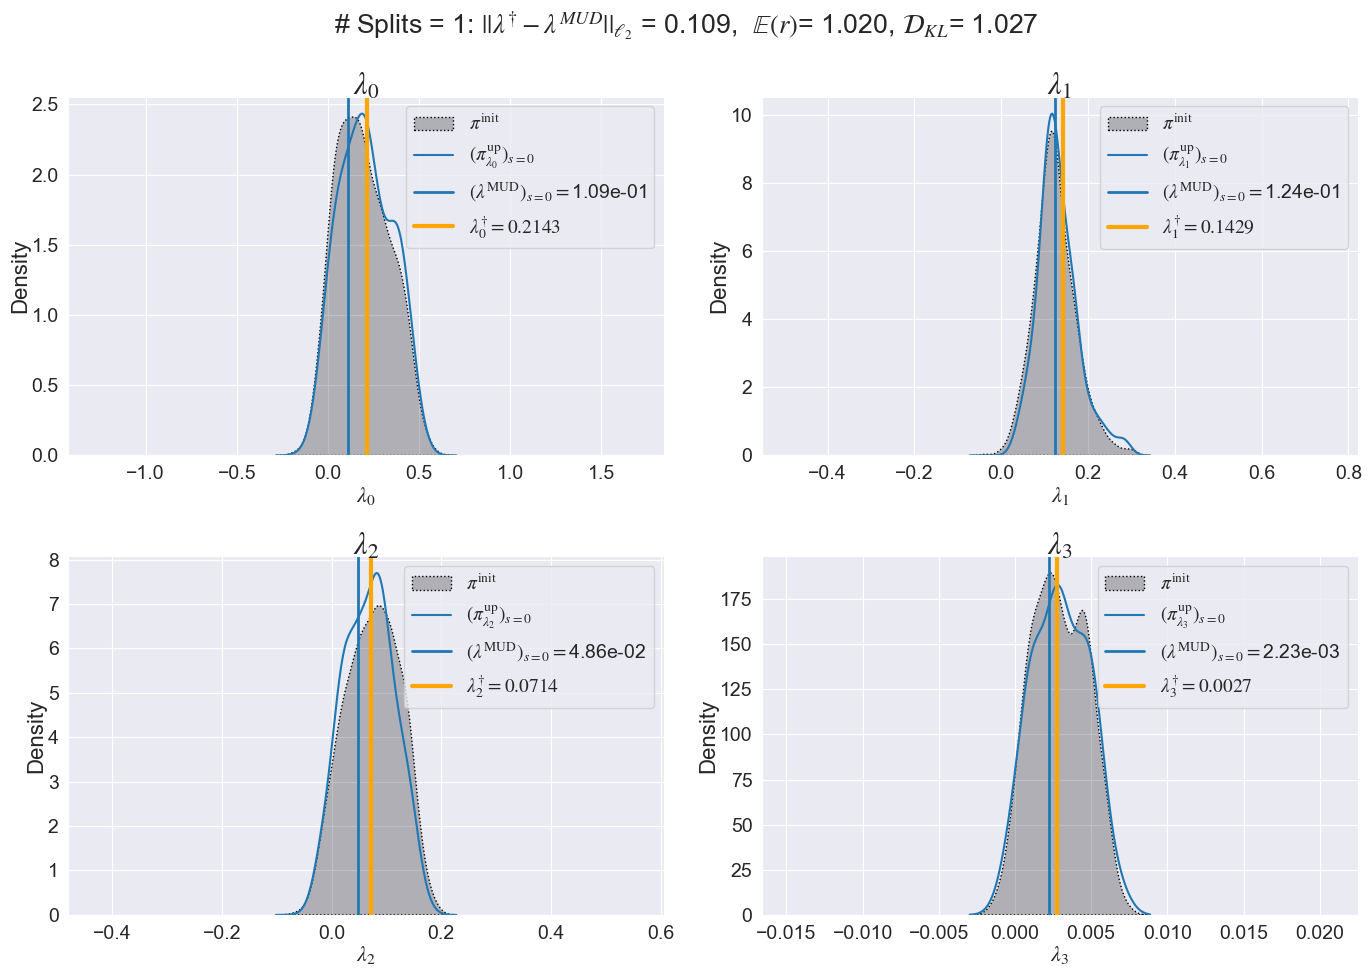

In [21]:
prob_2.param_density_plots(search_idxs=[0], lam_true=sr.lam_true)

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

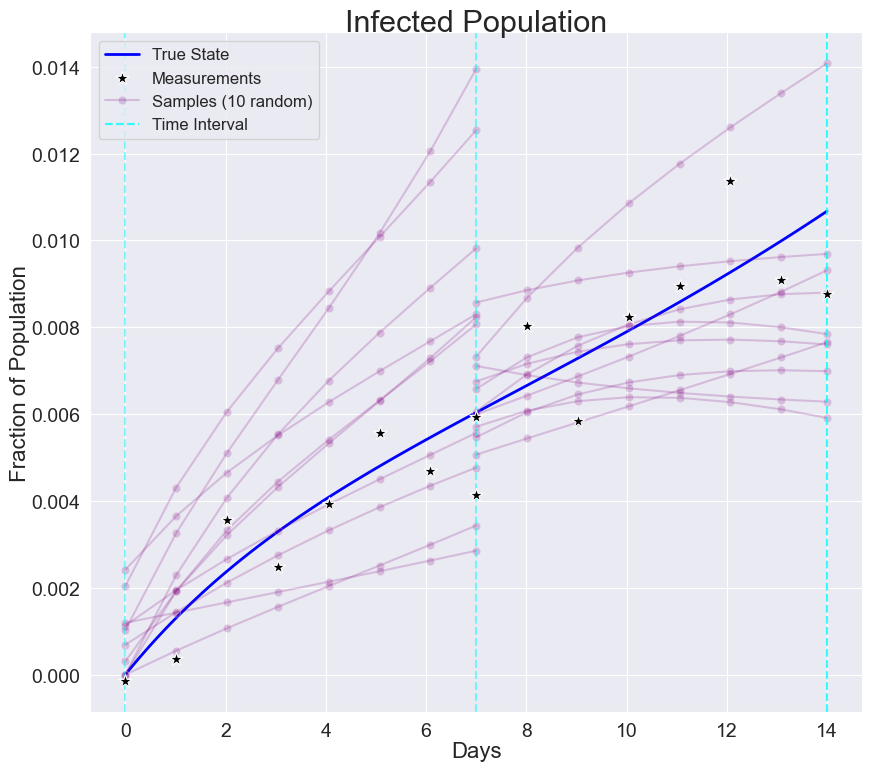

In [22]:
sr.plot_infected()

### Third Iteration

In [23]:
_ = prob_2.best.sample_dist(1, dist='pi_up')
pi_up_2 = prob_2.best.dists["pi_up"]
pi_up_2

In [24]:
disable_log()

try:
    sr.get_data(tf=21)
except ValueError as v:
    print(v)

In [25]:
enable_log(level='DEBUG', file='test.log')
prob_3 = solve_till_thresh(
    sr,
    2,
    clear=True,
    start_sample_size=1000,
    max_sample_size=2000,
    samples_inc=100,
    pi_in=pi_up_2,
    sampling_args={'scale': 1.0},
    search_exp_thresh=1e10,
    best_method='closest',
)
prob_3.n_samples

Solving for different combinations |████████████████████████████████████████| 8/


1000

In [26]:
prob_3.result

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,num_splits,search_index,predict_delta,within_thresh,closest,max_kl,min_kl
0,1.00707,1.186323,0.22467,0.121905,0.052706,0.002733,685,[0],"range(4, 8)",2,1,0.00707,True,True,False,False


In [27]:
prob_3.full_search_results

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,i,num_splits,search_index,predict_delta,within_thresh,closest,max_kl,min_kl
0,1.016741,1.005666,0.056487,0.125145,0.035607,0.001845,509,[0],"range(0, 8)",0,1,0,0.016741,True,False,False,False
0,1.017053,0.277391,0.229856,0.129793,0.087293,0.001107,752,[0],"range(0, 4)",0,2,1,0.017053,True,False,False,True
0,1.007070,1.186323,0.224670,0.121905,0.052706,0.002733,685,[0],"range(4, 8)",1,2,1,0.007070,True,True,False,False
0,1.059818,1.339004,0.225138,0.125005,0.067905,0.001367,775,"[0, 1]","range(0, 8)",0,1,2,0.059818,True,False,True,False
0,0.815182,0.640658,0.144128,0.132482,0.085639,0.004346,497,"[0, 1]","range(0, 4)",0,2,3,0.184818,False,False,False,False
0,0.660789,2.034328,0.427007,0.109071,0.107741,0.000049,228,"[0, 1]","range(4, 8)",1,2,3,0.339211,False,False,False,False
0,0.436395,1.663752,0.392479,0.079959,0.043590,0.003510,75,"[0, 1, 2]","range(0, 8)",0,1,4,0.563605,False,False,False,False
0,0.281689,0.771919,0.359157,0.124978,0.129201,0.001462,857,"[0, 1, 2]","range(0, 4)",0,2,5,0.718311,False,False,False,False
0,0.019167,2.226785,0.427007,0.109071,0.107741,0.000049,228,"[0, 1, 2]","range(4, 8)",1,2,5,0.980833,False,False,False,False
0,0.024806,1.781637,0.392479,0.079959,0.043590,0.003510,75,"[0, 1, 2, 3]","range(0, 8)",0,1,6,0.975194,False,False,False,False


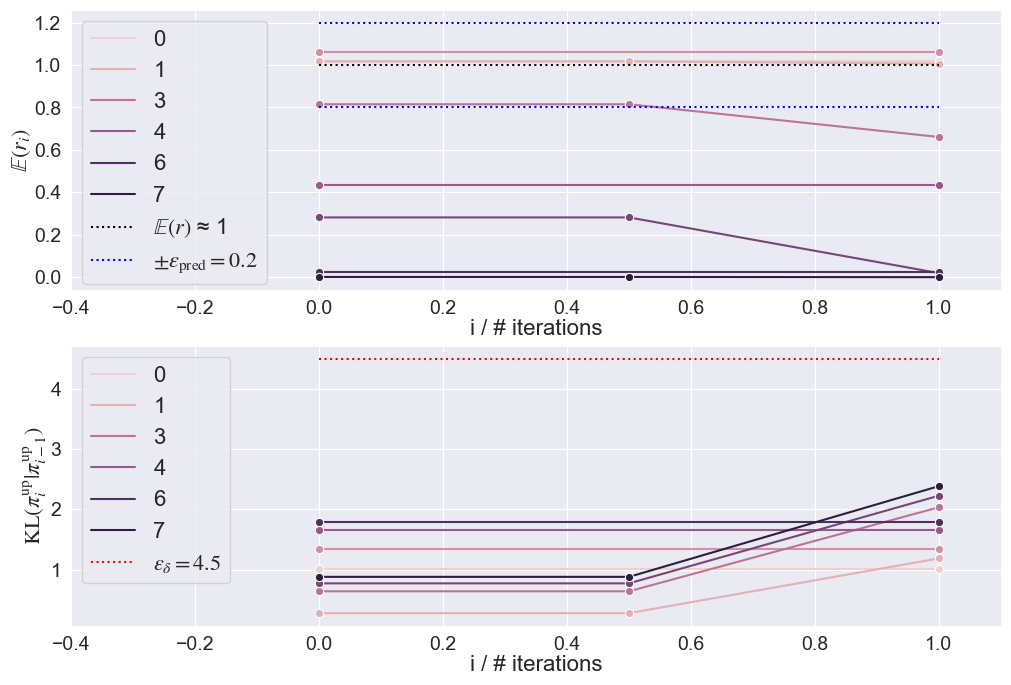

In [28]:
# TODO: Fade-out those that violate criteria?
prob_3.joint_metric_plot()

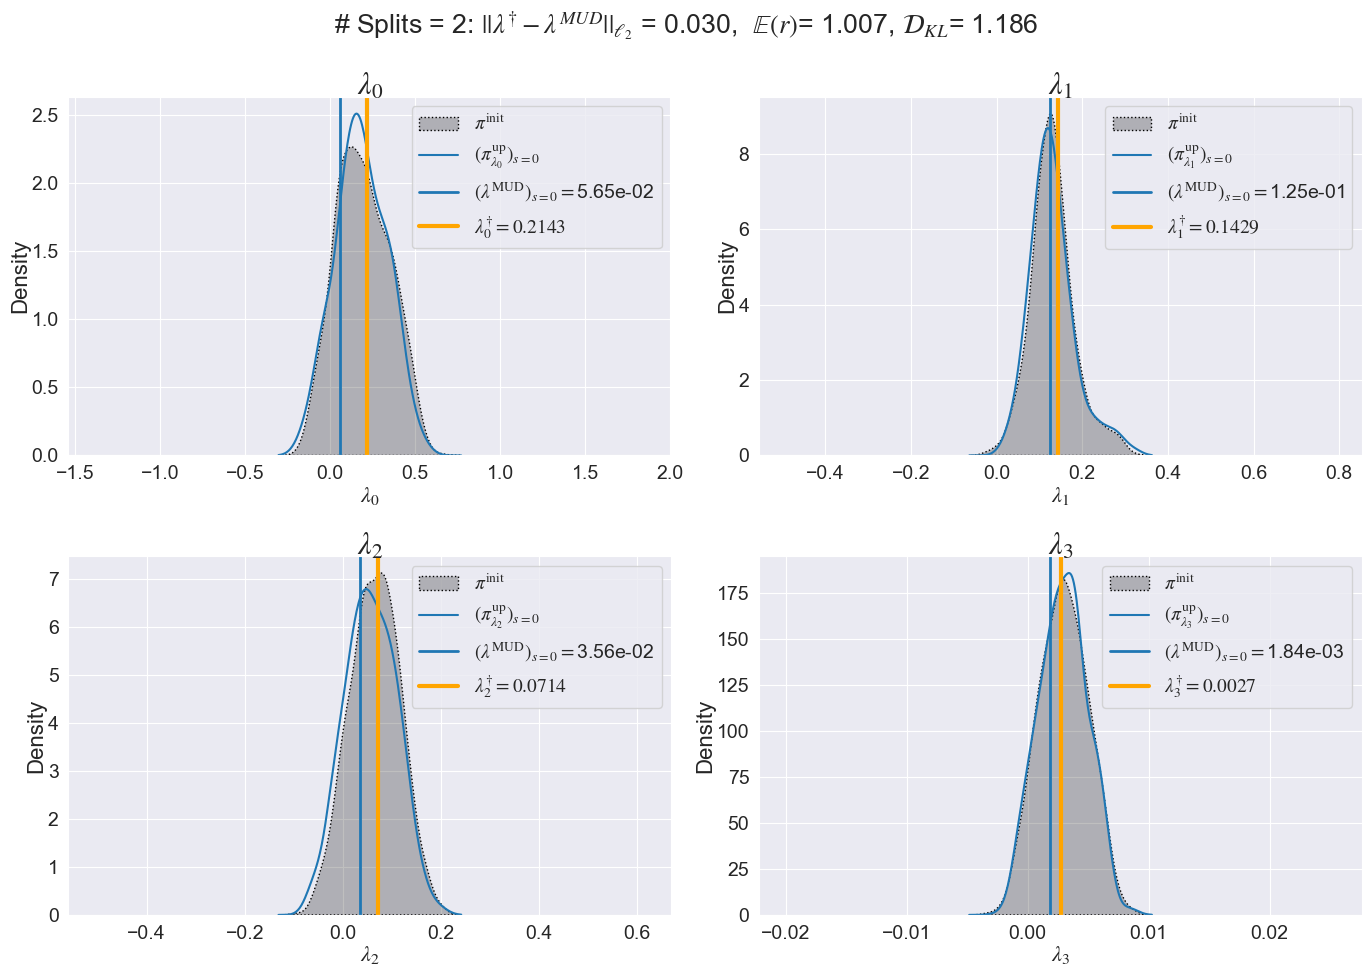

In [29]:
prob_3.param_density_plots(search_idxs=[0], lam_true=sr.lam_true)

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

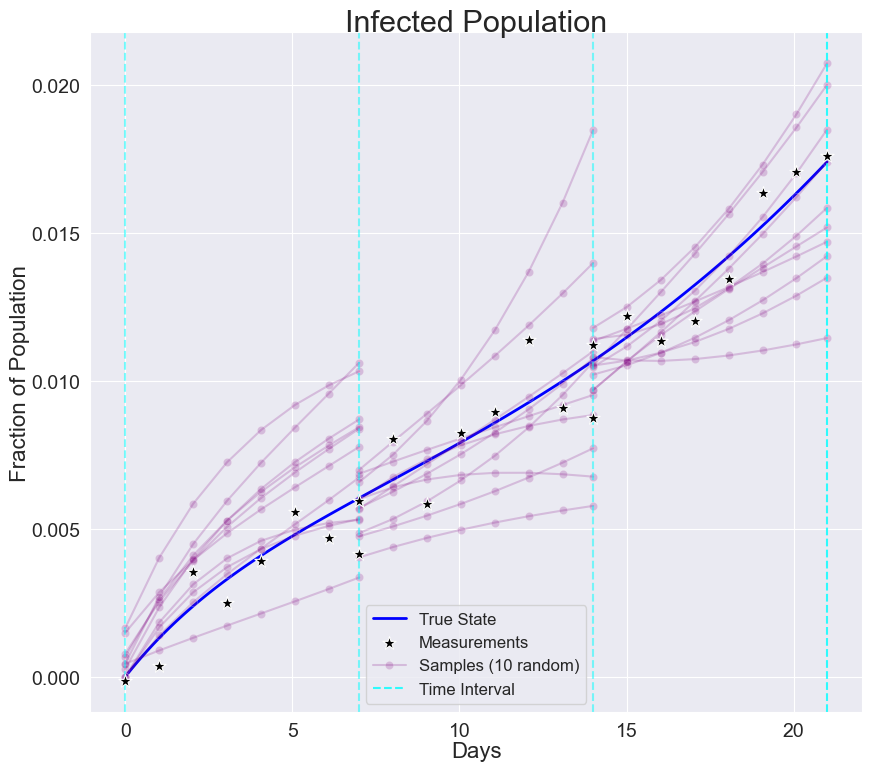

In [30]:
sr.plot_infected()

### Fourth Iteration -> Shift

In [31]:
_ = prob_3.best.sample_dist(1, dist='pi_up')
pi_up_3 = prob_3.best.dists["pi_up"]
pi_up_3

In [32]:
disable_log()

try:
    sr.get_data(tf=28)
except ValueError as v:
    print(v)

In [33]:
enable_log(level='DEBUG', file='test.log')
prob_4 = solve_till_thresh(
    sr,
    3,
    clear=True,
    start_sample_size=1000,
    max_sample_size=2000,
    samples_inc=100,
    pi_in=pi_up_3,
    sampling_args={'scale': 1.0},
    search_exp_thresh=1e10,
    best_method='closest',
)
prob_3.n_samples

Solving for different combinations |████████████████████████████████████████| 8/


1000

In [34]:
prob_4.result

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,num_splits,search_index,predict_delta,within_thresh,closest,max_kl,min_kl
0,1.022394,0.859212,0.148429,0.101681,0.022108,0.002994,855,[0],"range(0, 8)",1,0,0.022394,True,True,False,False


In [35]:
prob_4.full_search_results

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,i,num_splits,search_index,predict_delta,within_thresh,closest,max_kl,min_kl
0,1.022394,0.859212,0.148429,0.101681,0.022108,0.002994,855,[0],"range(0, 8)",0,1,0,0.022394,True,False,False,False
0,1.019097,0.328089,0.148429,0.101681,0.022108,0.002994,855,[0],"range(0, 4)",0,2,1,0.019097,True,False,False,True
0,1.050886,0.611181,0.148429,0.101681,0.022108,0.002994,855,[0],"range(4, 8)",1,2,1,0.050886,True,False,False,False
0,1.108784,0.985572,0.148429,0.101681,0.022108,0.002994,855,"[0, 1]","range(0, 8)",0,1,2,0.108784,False,False,False,False
0,0.989152,0.374624,0.326645,0.104748,0.062625,0.002164,930,"[0, 1]","range(0, 4)",0,2,3,0.010848,True,True,False,False
0,0.807305,1.426775,-0.078530,0.097718,-0.042982,0.003912,666,"[0, 1]","range(4, 8)",1,2,3,0.192695,False,False,False,False
0,1.095324,1.079093,0.082803,0.119006,0.011793,0.004123,193,"[0, 1, 2]","range(0, 8)",0,1,4,0.095324,True,False,True,False
0,0.398225,0.460277,0.364700,0.139254,0.088873,0.001306,941,"[0, 1, 2]","range(0, 4)",0,2,5,0.601775,False,False,False,False
0,0.071772,1.626104,0.073329,0.192106,0.046058,0.002923,888,"[0, 1, 2]","range(4, 8)",1,2,5,0.928228,False,False,False,False
0,0.068811,1.253141,-0.078530,0.097718,-0.042982,0.003912,666,"[0, 1, 2, 3]","range(0, 8)",0,1,6,0.931189,False,False,False,False


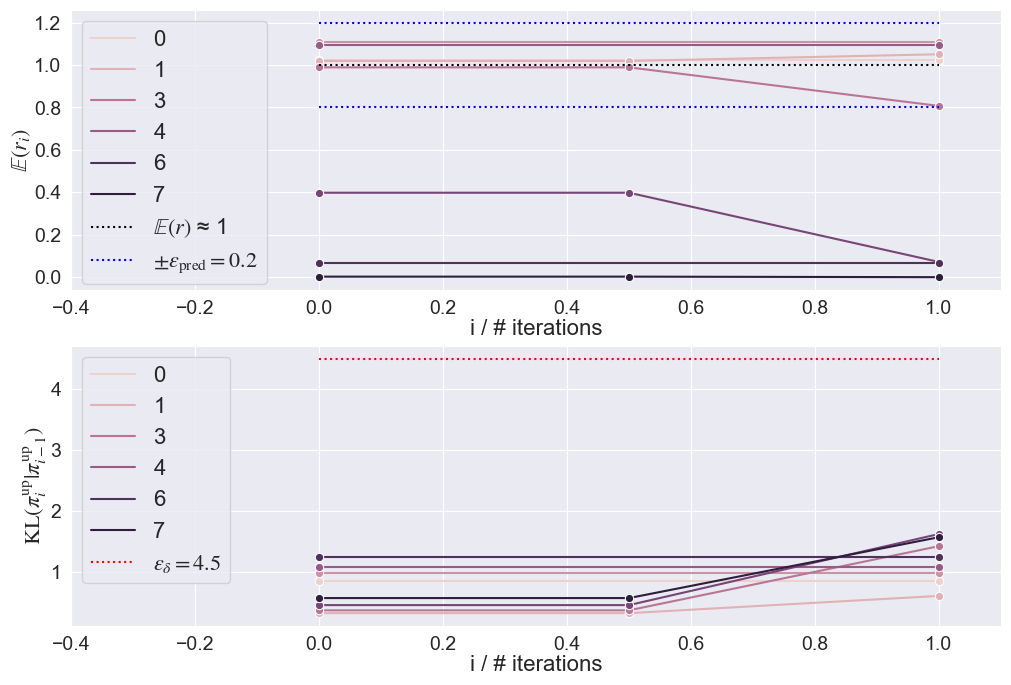

In [36]:
# TODO: Fade-out those that violate criteria?
prob_4.joint_metric_plot()

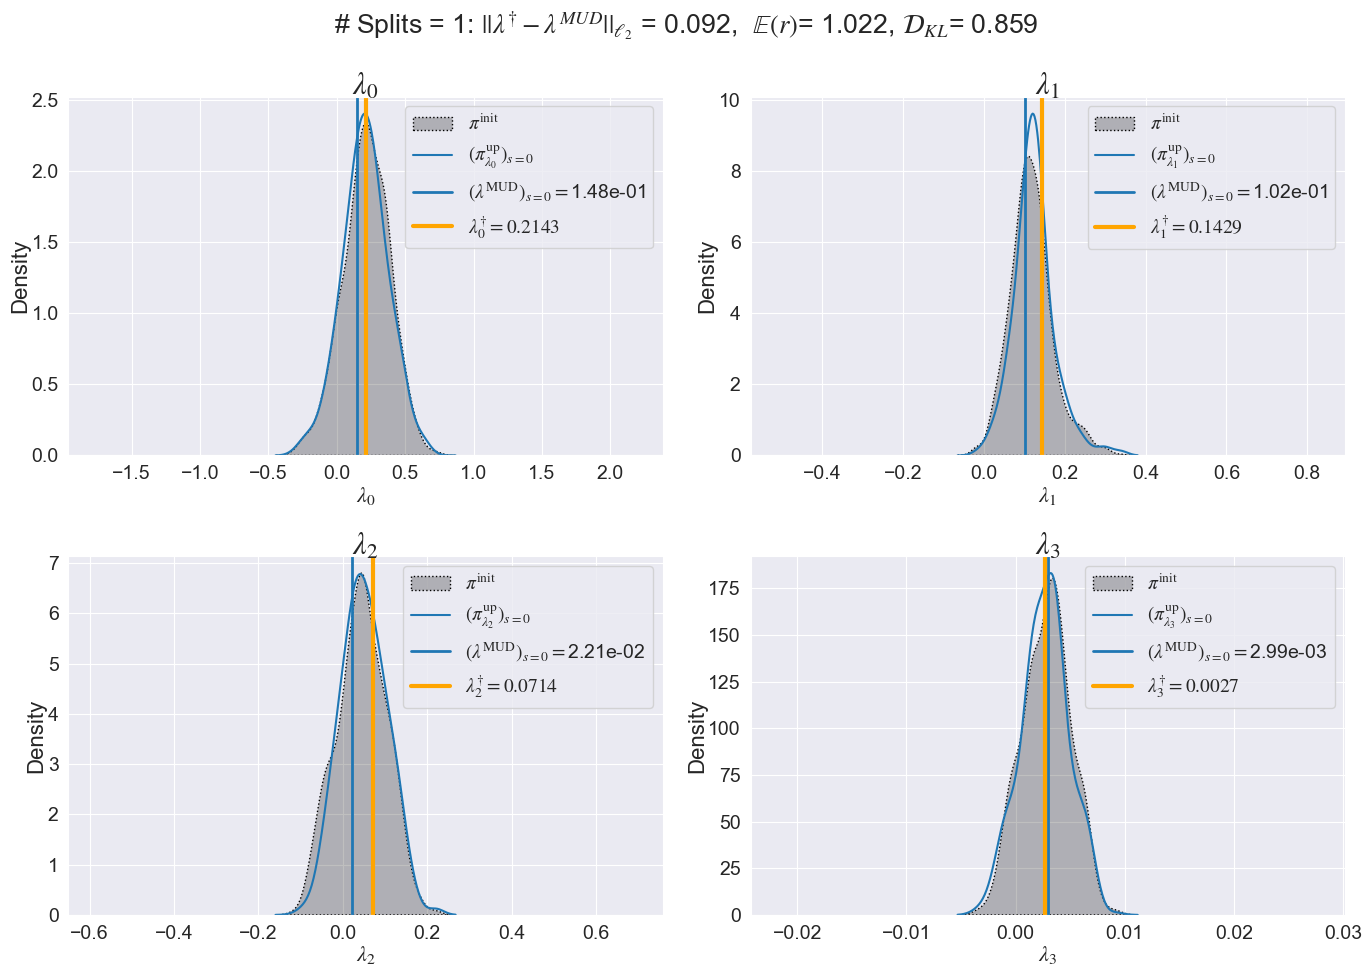

In [37]:
prob_4.param_density_plots(search_idxs=[0], lam_true=sr.lam_true)

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

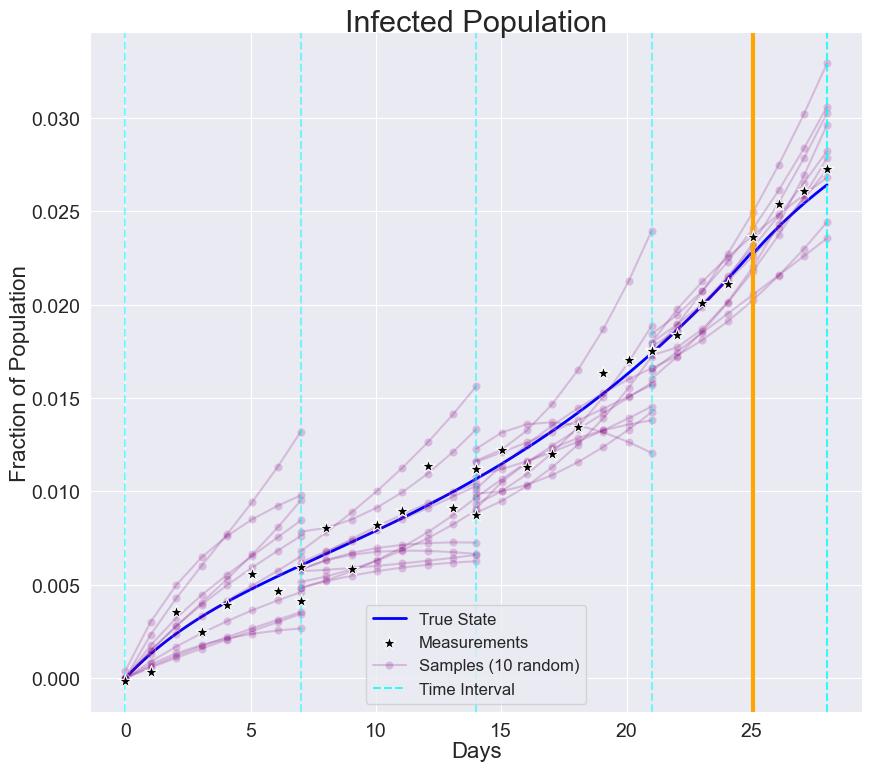

In [38]:
sr.plot_infected()

### Fifth Iteration

In [46]:
_ = prob_4.best.sample_dist(1, dist='pi_up')
pi_up_4 = prob_4.best.dists["pi_up"]
pi_up_4

In [47]:
disable_log()

try:
    sr.get_data(tf=35)
except ValueError as v:
    print(v)

tf=35 must be greater than last time-step 35.0.


In [50]:
enable_log(level='DEBUG', file='test.log')
prob_5 = solve_till_thresh(
    sr,
    4,
    clear=True,
    start_sample_size=1000,
    max_sample_size=2000,
    samples_inc=100,
    pi_in=pi_up_4,
    sampling_args={'scale': 1.0},
    search_exp_thresh=1e10,
    best_method='closest',
)
prob_5.n_samples

Solving for different combinations |████████████████████████████████████████| 8/


1000

In [51]:
prob_5.result

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,num_splits,search_index,predict_delta,within_thresh,closest,max_kl,min_kl
0,1.019941,5.35949,0.160444,0.185894,0.097407,0.003359,96,"[0, 1, 2]","range(0, 8)",1,4,0.019941,True,True,True,False


In [52]:
prob_5.full_search_results

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,i,num_splits,search_index,predict_delta,within_thresh,closest,max_kl,min_kl
0,0.951243,3.407697,0.267751,0.118526,0.073961,0.004080,327,[0],"range(0, 8)",0,1,0,0.048757,True,False,False,False
0,1.028025,0.516596,0.129756,0.103728,0.021203,0.003032,173,[0],"range(0, 4)",0,2,1,0.028025,True,False,False,True
0,1.046825,4.389929,0.092417,0.228241,0.095879,0.002454,213,[0],"range(4, 8)",1,2,1,0.046825,True,False,False,False
0,1.116138,4.946438,0.092417,0.228241,0.095879,0.002454,213,"[0, 1]","range(0, 8)",0,1,2,0.116138,False,False,False,False
0,0.955794,0.868674,0.463305,0.136731,0.139608,0.000595,322,"[0, 1]","range(0, 4)",0,2,3,0.044206,True,False,False,False
0,0.978185,4.127713,0.506909,0.012814,0.009651,-0.000207,262,"[0, 1]","range(4, 8)",1,2,3,0.021815,True,False,False,False
0,1.019941,5.359490,0.160444,0.185894,0.097407,0.003359,96,"[0, 1, 2]","range(0, 8)",0,1,4,0.019941,True,True,True,False
0,0.582425,1.010470,0.463305,0.136731,0.139608,0.000595,322,"[0, 1, 2]","range(0, 4)",0,2,5,0.417575,False,False,False,False
0,0.026239,3.993335,0.506909,0.012814,0.009651,-0.000207,262,"[0, 1, 2]","range(4, 8)",1,2,5,0.973761,False,False,False,False
0,0.096194,5.366543,0.160444,0.185894,0.097407,0.003359,96,"[0, 1, 2, 3]","range(0, 8)",0,1,6,0.903806,False,False,False,False


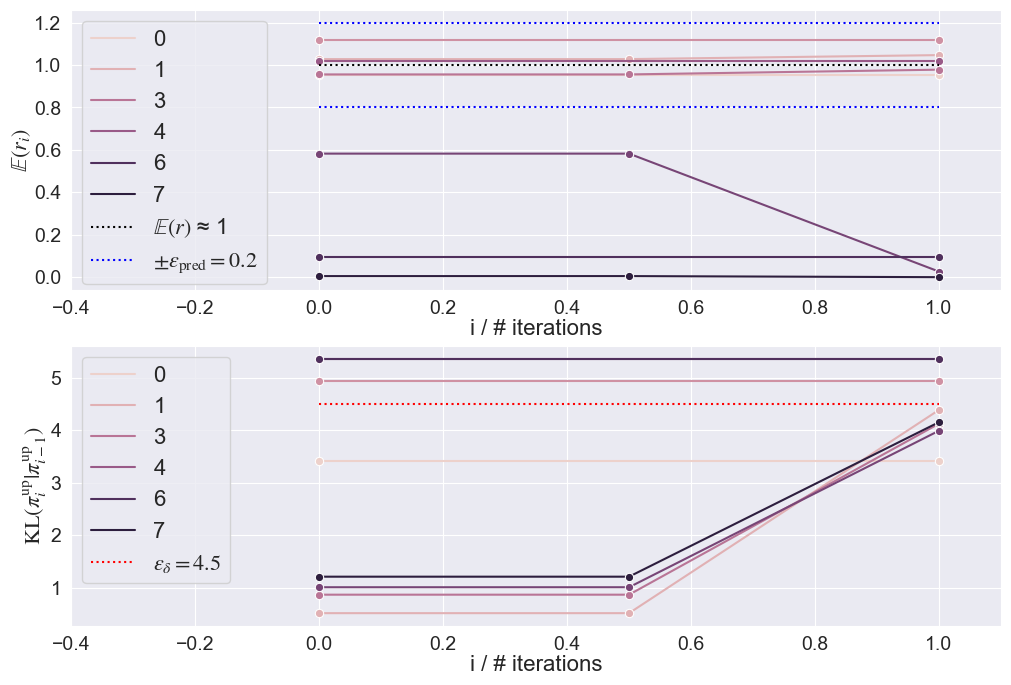

In [64]:
# TODO: Fade-out those that violate criteria?
prob_5.joint_metric_plot()

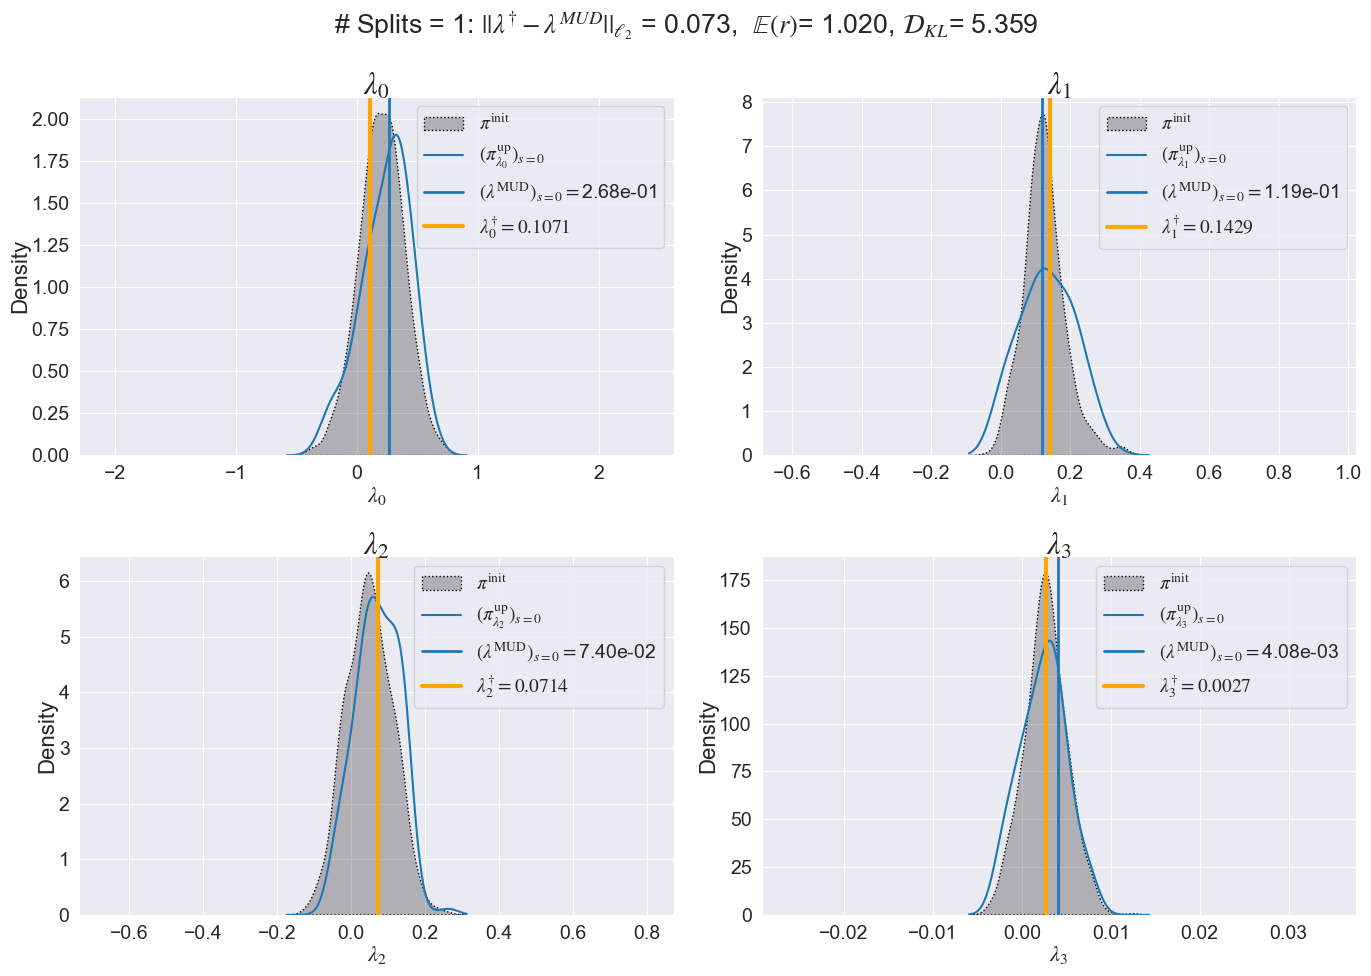

In [65]:
prob_5.param_density_plots(search_idxs=[0], lam_true=np.array([SEIRS_P2]))

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

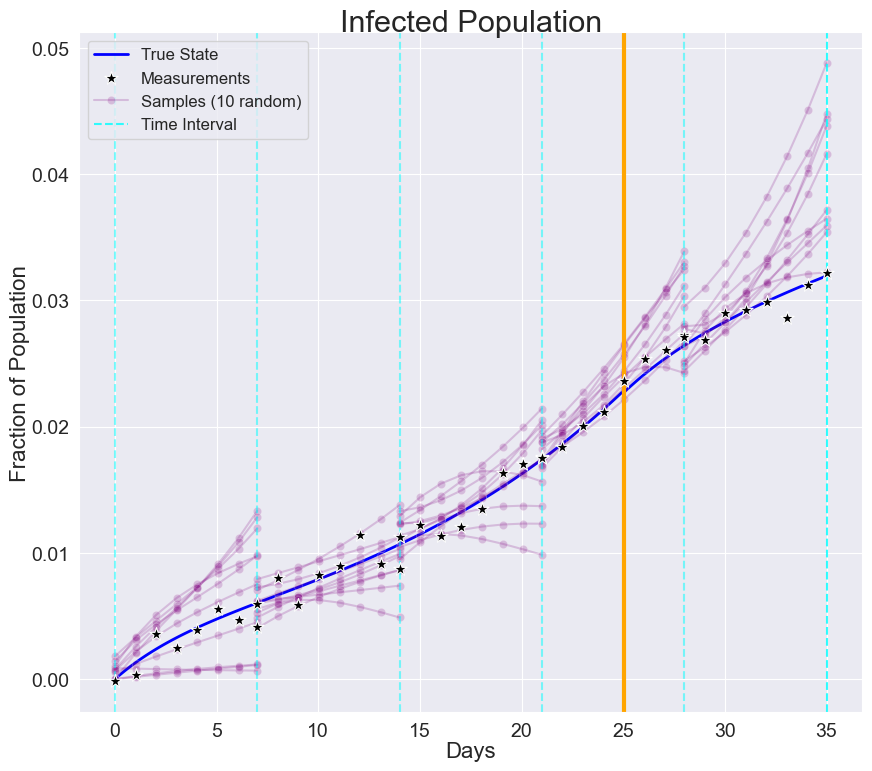

In [66]:
sr.plot_infected()

### Fifth Iteation - Retrying

Retry chunk, but reset to initial distribution.


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (6647.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

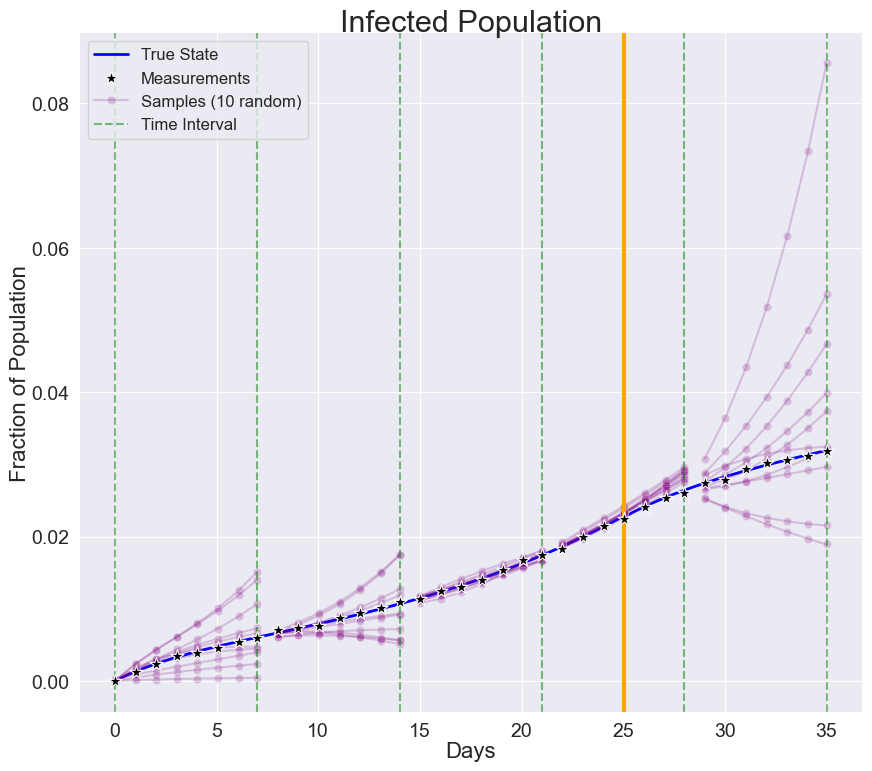

In [ ]:
pi_in, samples = sr.get_uniform_initial_samples(num_samples=n_samples, scale=1.0)
sr.forward_solve(samples)
sr.plot_infected()

In [ ]:
search_combs = sr.get_search_combinations(
    max_nc=max_nc, data_chunk_size=data_chunk_size
)
pd.DataFrame(search_combs)

,exp_thresh,pca_components,pca_mask,pca_splits
0,1.000000e+10,[[0]],"(0, 1, 2, 3, 4, 5, 6)",1
1,1.000000e+10,"[[0, 1]]","(0, 1, 2, 3, 4, 5, 6)",1
2,1.000000e+10,"[[0, 1, 2]]","(0, 1, 2, 3, 4, 5, 6)",1


In [ ]:
disable_log()
res_5 = sr.solve_search(search_combs, exp_thresh=0.5, best_method="max_kl", pi_in=pi_in)
search_res_5 = get_l2_errs(res_5["search_results"], SEIRS_P1)
best.append(res_5["best"])

Solving for different combinations |████████████████████████████████████████| 3/


In [ ]:
search_res_5

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,i,index,predict_delta,within_thresh,closest,max_kl,min_kl,l2_err,rel_err
0,1.201652,3.707657,0.070814,0.099673,0.041858,0.001024,602,[0],"range(0, 7)",0,0,0.201652,True,True,False,True,0.15273,0.571433
0,1.675196,6.133261,0.070814,0.099673,0.041858,0.001024,602,"[0, 1]","range(0, 7)",0,1,0.675196,False,False,False,False,0.15273,0.571433
0,1.281728,5.935910,0.070814,0.099673,0.041858,0.001024,602,"[0, 1, 2]","range(0, 7)",0,2,0.281728,True,False,True,False,0.15273,0.571433


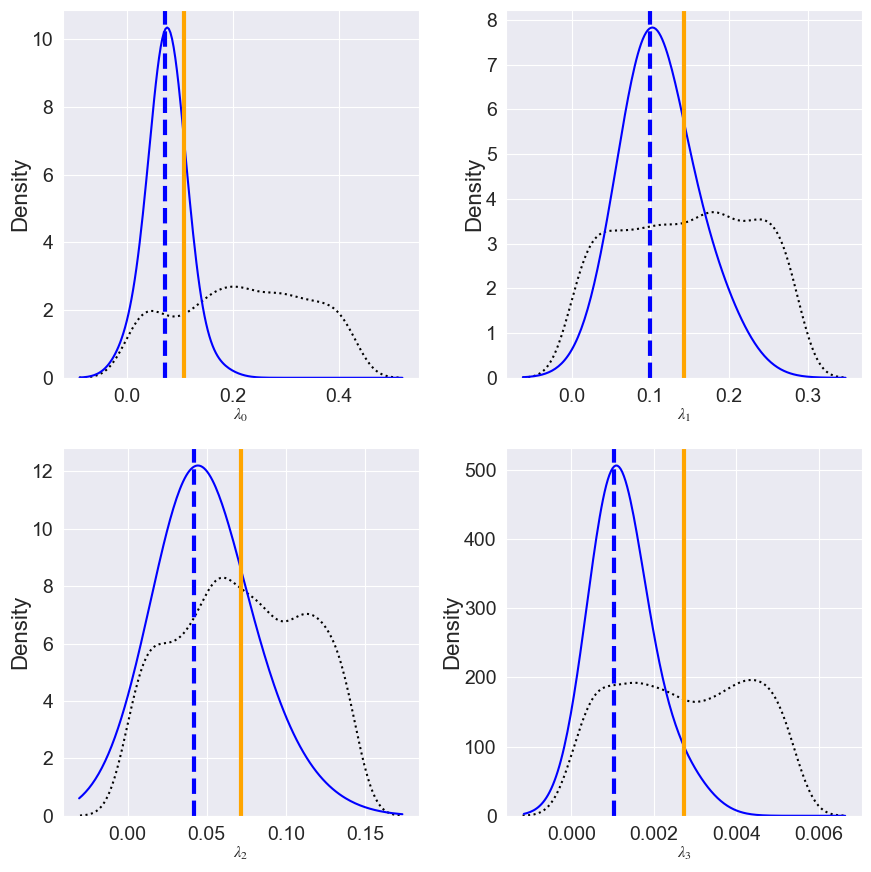

In [ ]:
plot_iterations(best, lam_true=[SEIRS_P2])